In [ ]:
!pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.5 MB/s eta 0:00:00


In [ ]:
import os
from shutil import rmtree

from google.colab import drive
from IPython.display import display, Audio
import jiwer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GRU, Input
from tensorflow.keras.layers import ReLU, Reshape, StringLookup

In [ ]:
def create_directory_if_not_exists(directory_path: str) -> None:
    assert directory_path is not None
    assert len(directory_path) != 0
    if os.path.isdir(directory_path):
        print(directory_path, 'exists, so it doesn\'t need to be created')
    else:
        os.makedirs(directory_path)
        print(directory_path, 'didn\'t exists and has just created')


drive.mount('/content/drive')

DATA_PATH = '/content/data'
create_directory_if_not_exists(DATA_PATH)

Mounted at /content/drive
/content/data didn't exists and has just created


In [ ]:
! unzip -q '/content/drive/MyDrive/Vô lấy hàng về này ae/datato2.zip' -d {DATA_PATH}
! cp '/content/drive/MyDrive/Vô lấy hàng về này ae/metadata02.csv' {DATA_PATH}

In [ ]:
metadata = pd.read_csv(DATA_PATH + '/metadata02.csv')
metadata.key = '/content/data' + metadata.key

metadata

,key,text,duration
0,/content/data/content/data/datato2/wavs/1/0.wav,HI. I'M VANESSA FROM SPEAKENGLISHWITHVANESSA.C...,10.407982
1,/content/data/content/data/datato2/wavs/1/1.wav,WHAT DO YOU DO? WHERE DO YOU WANT TO GO? WHAT ...,7.359025
2,/content/data/content/data/datato2/wavs/1/2.wav,SPEAKING WITH ME ABOUT SEVEN OF THE MOST COMMO...,5.601995
3,/content/data/content/data/datato2/wavs/1/3.wav,"VOCABULARY, QUESTIONS, SAMPLE CONVERSATION, PL...",5.032993
4,/content/data/content/data/datato2/wavs/1/4.wav,CONVERSATION PRACTICE CONVERSATION WITH ME TOO...,6.181995
...,...,...,...
4672,/content/data/content/data/datato2/wavs/11/937...,"ALSO, AT THE BOTTOM OF THE EBOOK, AT THE VERY ...",5.900023
4673,/content/data/content/data/datato2/wavs/11/938...,SO THAT YOU NEVER FORGET WHAT YOU'VE LEARNED. ...,9.244014
4674,/content/data/content/data/datato2/wavs/11/939...,THE NEXT STEP IS TO DOWNLOAD THE FREE PDF WORK...,6.000000
4675,/content/data/content/data/datato2/wavs/11/940...,"WITH THIS FREE PDF, YOU WILL MASTER TODAY'S LE...",7.000000


In [ ]:
temp = 0
try:
    item = metadata.iloc[temp]
    print(temp, item.key)
    print(item.text)
    display(Audio(item.key, autoplay=True))
except Exception as err:
    print(err, f'Index {temp} not found in metadata')

0 /content/data/content/data/datato2/wavs/1/0.wav
HI. I'M VANESSA FROM SPEAKENGLISHWITHVANESSA.COM. ARE YOU READY TO PRACTICE SPEAKING IN ENGLISH WITH ME? LET'S DO IT.


In [ ]:
from datetime import timedelta

print(f'{timedelta(seconds=sum(metadata.duration))} of audio in total')

7:48:50.011247 of audio in total


Dữ liệu hiện có khoảng 7 giờ 48 phút âm thanh.

Đây là phần dữ liệu sẽ được chia thành tập training, validation và tesing, theo tỷ lệ 80/10/10.

Train qua 50 epoch.

In [ ]:
# The random_state value should never be changed

train_metadata, valid_metadata, test_metadata = np.split(
    metadata.sample(frac=1, random_state=230713),
    [int(0.8 * len(metadata)), int(0.9 * len(metadata))]
)

print('Number of rows in training   metadata:', len(train_metadata))
print('Number of rows in validation metadata:', len(valid_metadata))
print('Number of rows in testing    metadata:', len(test_metadata))

Number of rows in training   metadata: 3741
Number of rows in validation metadata: 468
Number of rows in testing    metadata: 468


In [ ]:
train_metadata

,key,text,duration
1439,/content/data/content/data/datato2/wavs/4/434.wav,"AT. THIS IS MY SPECIFIC EMAIL ADDRESS. ""YOU CA...",8.551995
2943,/content/data/content/data/datato2/wavs/8/301.wav,VANESSA: THE NEXT STEP IS TO DOWNLOAD THE FREE...,9.000000
3727,/content/data/content/data/datato2/wavs/10/361...,HOW DID YOU DO? DID YOU HAVE A CHANCE TO SPEAK...,5.667982
4280,/content/data/content/data/datato2/wavs/11/545...,HOW ARE YOU DOING? I'M GOOD. HOW ARE YOU? YOU ...,3.123016
2098,/content/data/content/data/datato2/wavs/6/355.wav,WHILE YOU'RE SEARCHING FOR A JOB. SO DON'T DO ...,8.110975
...,...,...,...
4605,/content/data/content/data/datato2/wavs/11/870...,CAN I GET A DOUBLE BED? CAN I GET TWO TWIN BED...,6.832018
950,/content/data/content/data/datato2/wavs/3/224.wav,THE EIGHTH WAY TO SAY I DON'T KNOW IS ANOTHER ...,5.720000
2782,/content/data/content/data/datato2/wavs/8/140.wav,"THREE, TWO, ONE. THE FORK IS IN FRONT OF THE C...",3.664014
3591,/content/data/content/data/datato2/wavs/10/225...,"UNFORTUNATELY, WE HAVE TO WAIT UNTIL OCTOBER U...",5.784989


Chuẩn bị bộ ký tự để chuyển đổi từ ký tự sang giá trị số.

In [ ]:
char_list = [
    '-', ' ', 'E', 'T', 'A',
    'O', 'N', 'I', 'H', 'S',
    'R', 'D', 'L', 'U', 'M',
    'W', 'C', 'F', 'G', 'Y',
    'P', 'B', 'V', 'K', "'",
    'X', 'J', 'Q', 'Z', '?',
    '!', '.', ','
]

# Maps character to integer
char_to_int = StringLookup(
    vocabulary=char_list,
    oov_token=''
)

# Maps integer to character
int_to_char = StringLookup(
    vocabulary=char_to_int.get_vocabulary(),
    oov_token='',
    invert=True
)

print(f'There are {char_to_int.vocabulary_size()} characters in total')

There are 34 characters in total


Mỗi mẫu dữ liệu bao gồm đường dẫn đến file WAV (wav_file) và label (label) sẽ được biến đổi để phù hợp với model:

- Dữ liệu âm thanh được đọc từ file thành tensor, rồi được chuyển sang dạng spectrogram. Dữ liệu spectrogram sẽ được chuẩn hóa.
- Label sẽ được chuyển từ văn bản thành mảng số.

In [ ]:
frame_length =  128     # The window length in each sample
frame_step =    160     # The number of samples to step
fft_length =    384     # The size of FFT to apply.
                        # If not provided, uses the smallest power of 2 enclosing frame_length

def encode_input(wav_file, label):
    '''
    Processes the audio file (WAV)
    '''

    global frame_length
    global frame_step
    global fft_length

    ############## AUDIO ##############

    # Reads the WAV file
    file_data = tf.io.read_file(wav_file)

    # Decodes the WAV file
    audio_data, _ = tf.audio.decode_wav(file_data)   # A float tensor
    audio_data = tf.squeeze(audio_data, axis=-1)          # Removes all dimension with size 1

    # Type-casts to float
    audio_data = tf.cast(audio_data, tf.float32)

    # Calculate the spectrogram
    # STFT stands for Short time Fourier transform
    spectrogram = tf.signal.stft(
        audio_data, frame_length=frame_length,
        frame_step=frame_step, fft_length=fft_length
    )

    # Calculate the magnitude
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)

    # Normalize
    means = tf.math.reduce_mean(spectrogram, axis=1, keepdims=True)
    std_devs = tf.math.reduce_std(spectrogram, axis=1, keepdims=True)
    spectrogram = (spectrogram - means) / (std_devs + 1e-10)

    ########### LABEL (TEXT) ###########

    # Convert the label to uppercase
    label = tf.strings.upper(label)

    # Split the label by blank characters (whitespaces, tabs etc.)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')

    # Maps each character in label to a number
    label = char_to_int(label)

    # Returns the spectrogram's result and the label, as our model need two inputs to train
    return spectrogram, label

Tạo đối tượng `tf.data.Dataset` từ metadata (theo tập train, valid và test).

In [ ]:
batch_size = 16

# Creates trainning, validation and testing datasets
train_dataset, valid_dataset, test_dataset = [
    tf.data.Dataset.from_tensor_slices(
        (list(df['key']), list(df['text']))
    ).map(encode_input, num_parallel_calls=tf.data.AUTOTUNE)
        .padded_batch(batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    for df in [train_metadata, valid_metadata, test_metadata]
]

print('Number of batches in training   dataset:', len(train_dataset))
print('Number of batches in validation dataset:', len(valid_dataset))
print('Number of batches in testing    dataset:', len(test_dataset))

Number of batches in training   dataset: 234
Number of batches in validation dataset: 30
Number of batches in testing    dataset: 30


Trực quan hóa dữ liệu

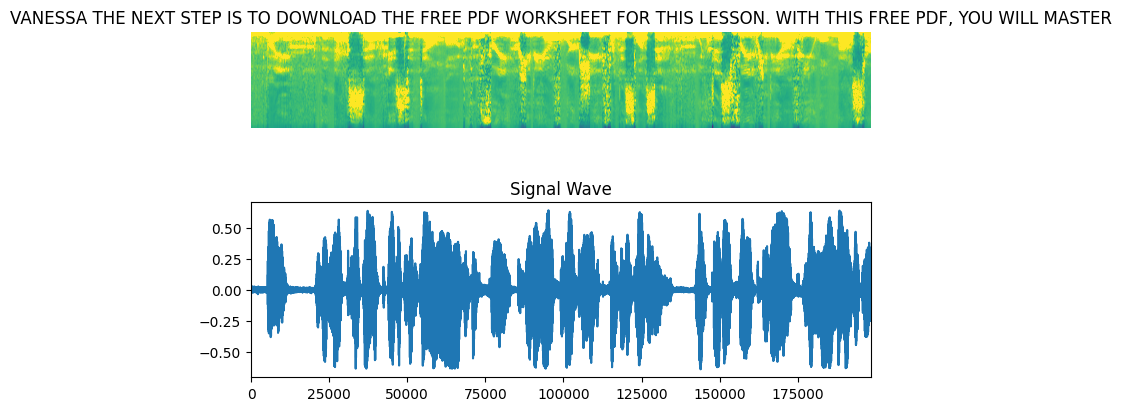

In [ ]:
temp = 1

fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][temp].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][temp]

    # Spectrogram
    label = tf.strings.reduce_join(int_to_char(label)).numpy().decode('UTF-8')
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis('off')

    # WAV
    file_data = tf.io.read_file(list(train_metadata['key'])[temp])
    audio, _ = tf.audio.decode_wav(file_data)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title('Signal Wave')
    ax.set_xlim(0, len(audio))
    display(Audio(np.transpose(audio), rate=16_000))
plt.show()

## Model for you

CTC Loss

In [ ]:
def ctc_loss(target, prediction):
    '''
    Computes the CTC loss value while training
    '''

    batch_size = tf.cast(tf.shape(target)[0], dtype='int64')
    input_size = tf.cast(tf.shape(prediction)[1], dtype='int64')
    label_size = tf.cast(tf.shape(target)[1], dtype='int64')

    temp = tf.ones(shape=(batch_size, 1), dtype='int64')
    input_size = input_size * temp
    label_size = label_size * temp

    loss = keras.backend.ctc_batch_cost(target, prediction, input_size, label_size)
    return loss

Model (theo báo cáo)

In [ ]:
def build_model(input_dim, output_dim, n_rnn_layers=5, n_rnn_units=128, lr=1e-4):
    '''
    A model inspired by Deep Speech 2
    '''

    # Input
    spectrogram = Input((None, input_dim), name='input')

    # Expand the dimension to use Conv2D
    x = Reshape((-1, input_dim, 1), name='expand_dim')(spectrogram)

    # CNN 1
    x = Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding='same',
        use_bias=False,
        name='conv_1'
    )(x)
    x = BatchNormalization(name='conv_1_bn')(x)
    x = ReLU(name='conv_1_relu')(x)

    # CNN 2
    x = Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding='same',
        use_bias=False,
        name='conv_2'
    )(x)
    x = BatchNormalization(name='conv_2_bn')(x)
    x = ReLU(name='conv_2_relu')(x)

    # Reshape the resulted volume to feed ththe layers of RNN
    x = Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN
    for i in range(1, n_rnn_layers + 1):
        recurrent = GRU(
            units=n_rnn_units,
            activation='tanh',
            recurrent_activation='sigmoid',
            use_bias='True',
            return_sequences=True,
            reset_after=True,
            name=f'gru_{i}'
        )
        x = Bidirectional(
            recurrent, name=f'bidirectional_{i}', merge_mode='concat'
        )(x)
        if i != n_rnn_layers:
            x = Dropout(rate=0.5)(x)

    # Dense
    x = Dense(units=n_rnn_units * 2, name='dense_1')(x)
    x = ReLU(name='dense_1_relu')(x)
    x = Dropout(rate=0.5)(x)

    # Classification
    output = Dense(units=output_dim + 1, activation='softmax')(x)

    # Model
    model = keras.Model(spectrogram, output, name='model')

    # Optimizer
    optim = keras.optimizers.Adam(learning_rate=lr)

    # Compile the model
    model.compile(optimizer=optim, loss=ctc_loss)
    return model

Tạo model

In [ ]:
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_int.vocabulary_size(),
    n_rnn_units=512
)

model.summary(line_length=100)

Model: "model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input (InputLayer)                          [(None, None, 193)]                     0              
                                                                                                    
 expand_dim (Reshape)                        (None, None, 193, 1)                    0              
                                                                                                    
 conv_1 (Conv2D)                             (None, None, 97, 32)                    14432          
                                                                                                    
 conv_1_bn (BatchNormalization)              (None, None, 97, 32)                    128            
                                                                            

## Train and validate

In [ ]:
def decode_batch_predictions(predictions):
    input_length = np.ones(predictions.shape[0]) * predictions.shape[1]

    # Greedy search
    results = keras.backend.ctc_decode(predictions, input_length=input_length, greedy=True)[0][0]

    output_texts = [
        tf.strings.reduce_join(int_to_char(result)).numpy().decode('UTF-8')
        for result in results
    ]

    return output_texts


class Evaluator(keras.callbacks.Callback):
    '''
    A callback class output a few transcriptions during training.
    Display a batch of outputs after each epoch.
    '''

    def __init__(self, dataset):
        super(Evaluator, self).__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []

        iterator = None
        iterator = iter(self.dataset)
        batch_count = 0

        while True:
            try:
                X, y = iterator.get_next()
                batch_predictions = model.predict(X, verbose=0)
                batch_predictions = decode_batch_predictions(batch_predictions)
                predictions.extend(batch_predictions)
                for label in y:
                    label = tf.strings.reduce_join(int_to_char(label)).numpy().decode('UTF-8')
                    targets.append(label)
            except tf.errors.OutOfRangeError:
                break

        # for batch in self.dataset:
        #     X, y = batch
        #     batch_predictions = model.predict(X, verbose=0)
        #     batch_predictions = decode_batch_predictions(batch_predictions)
        #     predictions.extend(batch_predictions)
        #     for label in y:
        #         label = tf.strings.reduce_join(int_to_char(label)).numpy().decode('UTF-8')
        #         targets.append(label)

        wer_score = jiwer.wer(targets, predictions)
        print('-' * 100)
        print(f'WER: {wer_score:.2%}')
        for i in np.random.randint(0, len(predictions), 2):
            print(f'Target    : {targets[i]}')
            print(f'Prediction: {predictions[i]}')
        print('-' * 100)


In [ ]:
# To load saved model
model = keras.models.load_model('/content/drive/My Drive/model-doan-datatuthuthap-epoch50.keras', custom_objects = {"ctc_loss": ctc_loss})

In [ ]:
# Number of epochs should be around 50 to 100
n_epochs = 50

# Callback function called on the validation dataset
valid_callback = Evaluator(valid_dataset)

assert n_epochs >= 0
assert n_epochs < 100

# Train
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    callbacks=[valid_callback]
)

Epoch 1/50
234/234 [==============================] - ETA: 0s - loss: 364.9630----------------------------------------------------------------------------------------------------
WER: 100.00%
Target    : TWO DIFFERENT OR MAYBE THREE OR FOUR DIFFERENT TYPES OF DOGS IN HIS BLOOD. SO WE COULD SAY HE'S
Prediction: 
Target    : I USED THAT SAME SOUND, MM-MM. MM-MM, VERY  STRONG, USUALLY SHAKING MY HEAD TRYING TO EXPRESS,
Prediction: 
----------------------------------------------------------------------------------------------------
234/234 [==============================] - 478s 2s/step - loss: 364.9630 - val_loss: 753.7321
Epoch 2/50
234/234 [==============================] - ETA: 0s - loss: 336.4954----------------------------------------------------------------------------------------------------
WER: 100.00%
Target    : WHEW. TO GET BACK AT, TO GET BACK AT. HMM.
Prediction: 
Target    : GOING INTO YOU. SO WHEN SOMEONE FILLS YOU IN, THE INFORMATION IS GOING IN.
Prediction: 
------------

In [ ]:
# Number of epochs should be around 50 to 100
n_epochs = 25

# Callback function called on the validation dataset
valid_callback = Evaluator(valid_dataset)

assert n_epochs >= 0
assert n_epochs < 100

# Train
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=n_epochs,
    callbacks=[valid_callback]
)

Epoch 1/25
234/234 [==============================] - ETA: 0s - loss: 108.6453----------------------------------------------------------------------------------------------------
WER: 68.52%
Target    : TALKING WITH HER ABOUT HER PROBLEMS MAKES ME  FEEL DRAINED. OR MAYBE WATCHING THESE LESSONS
Prediction: TOKING WAS HAR ABOUT AR PROBONS MAKES  ME FEL DRAIN OR MAYBE WATIN
Target    : UP EARLY IN THE MORNING GET THE BEST WORMS. IF YOU  WAIT, IF YOU PROCRASTINATE, WELL TOO BAD FOR YOU,
Prediction: VERALY IN THE MORING GIT TO BEST WORDS YOU WIT IF YOU PERRESANA WE   
----------------------------------------------------------------------------------------------------
234/234 [==============================] - 1510s 6s/step - loss: 108.6453 - val_loss: 218.9871
Epoch 2/25
234/234 [==============================] - ETA: 0s - loss: 106.6817----------------------------------------------------------------------------------------------------
WER: 68.95%
Target    : BUT NO, YOU ARE THE ONE WHO'S T

## Inference

In [ ]:
predictions = []
targets = []

iterator = iter(test_dataset)
while True:
    try:
        X, y = iterator.get_next()
        batch_predictions = model.predict(X)
        batch_predictions = decode_batch_predictions(batch_predictions)
        predictions.extend(batch_predictions)
        for label in y:
            label = tf.strings.reduce_join(int_to_char(label)).numpy().decode('UTF-8')
            targets.append(label)
    except tf.errors.OutOfRangeError:
        break

wer_score = jiwer.wer(targets, predictions)
print('-' * 100)
print(f'WER: {wer_score:.2%}')
for i in np.random.randint(0, len(predictions), 2):
    print(f'Target    : {targets[i]}\n')
    print(f'Prediction: {predictions[i]}\n')
print('-' * 100)

1/1 [==============================] - 2s 2s/step


## Save the model to Google Drive

In [ ]:
model.save('/content/drive/My Drive/model-doan-datatuthuthap-epoch75.keras')

# To load saved model
# model = keras.models.load_model(<full path to file>)